# EXPLICAR DO QUE SE TRATA O PROJETO

In [1]:
import os
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import Callback

In [2]:
# Carregar o arquivo CSV
csv_path = os.path.join(r'F:\NIH Chest X-rays', 'Data_Entry_2017.csv')
df = pd.read_csv(csv_path)

# ENTENDIMENTO DA BASE

In [3]:
# Visualizar as ultimas linhas do DataFrame
# Assim já da pra ver que a base tem 112120 linhas, devido a linha 0
df.tail()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN
112119,00030805_000.png,No Finding,0,30805,27,M,PA,2048,2500,0.171,0.171,NaN


### Combinações de valores únicos
<br>

##### A quantidade de valores únicos acabou ficando gigantesco, pois a junção das condições encontradas também formam um valor único, por exemplo:  'Effusion|Mass'.

In [4]:
df['Finding Labels'].unique()

array(['Cardiomegaly', 'Cardiomegaly|Emphysema', 'Cardiomegaly|Effusion',
       'No Finding', 'Hernia', 'Hernia|Infiltration', 'Mass|Nodule',
       'Infiltration', 'Effusion|Infiltration', 'Nodule', 'Emphysema',
       'Effusion', 'Atelectasis', 'Effusion|Mass',
       'Emphysema|Pneumothorax', 'Pleural_Thickening',
       'Effusion|Emphysema|Infiltration|Pneumothorax',
       'Emphysema|Infiltration|Pleural_Thickening|Pneumothorax',
       'Effusion|Pneumonia|Pneumothorax', 'Pneumothorax',
       'Effusion|Infiltration|Pneumothorax', 'Infiltration|Mass',
       'Infiltration|Mass|Pneumothorax', 'Mass',
       'Cardiomegaly|Infiltration|Mass|Nodule',
       'Cardiomegaly|Effusion|Emphysema|Mass',
       'Atelectasis|Cardiomegaly|Emphysema|Mass|Pneumothorax',
       'Emphysema|Mass', 'Emphysema|Mass|Pneumothorax',
       'Atelectasis|Pneumothorax', 'Cardiomegaly|Emphysema|Pneumothorax',
       'Mass|Pleural_Thickening', 'Cardiomegaly|Mass|Pleural_Thickening',
       'Effusion|Infiltra

In [5]:
# Quantidade de valores únicos
df['Finding Labels'].nunique()

836

### Condições Básicas e Suas Definições

1. **Cardiomegaly**  
   Aumento anormal do tamanho do coração.

2. **Emphysema**  
   Doença pulmonar obstrutiva crônica que danifica os alvéolos pulmonares.

3. **Effusion**  
   Acúmulo anormal de líquido, como derrame pleural.

4. **Atelectasis**  
   Colapso parcial ou total do pulmão.

5. **Pneumonia**  
   Infecção que inflama os sacos de ar nos pulmões.

6. **Pneumothorax**  
   Presença de ar na cavidade pleural, causando colapso do pulmão.

7. **Nodule**  
   Pequena massa de tecido, que pode ser benigna ou maligna.

8. **Mass**  
   Lesão ou crescimento anormal de tecido.

9. **Fibrosis**  
   Espessamento e cicatrização do tecido pulmonar.

10. **Edema**  
    Acúmulo de líquido nos pulmões, frequentemente associado a insuficiência cardíaca.

11. **Pleural_Thickening**  
    Espessamento da pleura, muitas vezes devido a inflamação ou cicatrização.

12. **Hernia**  
    Protusão de um órgão ou tecido através de uma abertura anormal.

13. **Infiltration**  
    Presença de substâncias anormais (como líquido ou células) no tecido pulmonar.

14. **Consolidation**  
    Substituição do ar nos alvéolos por líquido, pus ou outros materiais.

15. **No Finding**  
    Nenhuma anomalia encontrada na imagem.

### Problema de balanceamento
<br>

##### Com o código abaixo já é um sinal de que terá que ser feito algo para lidar com desbalanceamento de classes, mas quero verificar isso mais afundo.

In [6]:
# Top 10 classes mais comuns
print(df['Finding Labels'].value_counts().head(10))
print('\n')
# Top 10 classes menos comuns
print(df['Finding Labels'].value_counts().tail(10))

Finding Labels
No Finding                  60361
Infiltration                 9547
Atelectasis                  4215
Effusion                     3955
Nodule                       2705
Pneumothorax                 2194
Mass                         2139
Effusion|Infiltration        1603
Atelectasis|Infiltration     1350
Consolidation                1310
Name: count, dtype: int64


Finding Labels
Emphysema|Infiltration|Pleural_Thickening|Pneumonia                  1
Atelectasis|Effusion|Fibrosis|Infiltration|Nodule                    1
Consolidation|Effusion|Mass|Nodule|Pleural_Thickening|Atelectasis    1
Effusion|Mass|Pneumonia|Pneumothorax                                 1
Atelectasis|Consolidation|Edema|Effusion|Pleural_Thickening          1
Atelectasis|Consolidation|Edema|Effusion|Infiltration|Pneumonia      1
Atelectasis|Consolidation|Effusion|Emphysema|Mass|Pneumothorax       1
Cardiomegaly|Effusion|Pleural_Thickening|Pneumothorax                1
Edema|Infiltration|Pneumothorax   

##### O que o gráfico abaixo traz de informação é que poucas classes como "No Finding" e "Infiltration" tem um número gigante de amostras, mas existe um número bem relevante de classes com poucas amostras, sendo que a maioria tem de 1-10 amostras apenas.

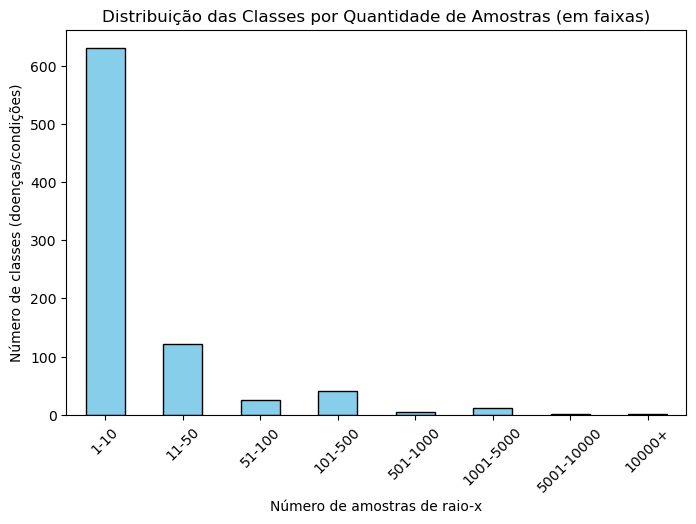

In [7]:
# Contar quantas imagens existem para cada classe
class_counts = df['Finding Labels'].value_counts()

# Criar faixas para contagem das classes
bins = [1, 10, 50, 100, 500, 1000, 5000, 10000, max(class_counts)]  
labels = ['1-10', '11-50', '51-100', '101-500', '501-1000', '1001-5000', '5001-10000', '10000+']

# Contar quantas classes caem em cada faixa
class_bins = pd.cut(class_counts, bins=bins, labels=labels, include_lowest=True)
bin_counts = class_bins.value_counts().sort_index()

# Plotar
plt.figure(figsize=(8, 5))
bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Número de amostras de raio-x')
plt.ylabel('Número de classes (doenças/condições)')
plt.title('Distribuição das Classes por Quantidade de Amostras (em faixas)')
plt.xticks(rotation=45)
plt.show()

# MODELAGEM DA BASE

### Estratégia
<br>

##### Como a base da dados tem 15 condições diferentes, incluindo o "No Finding" e essas condições podem se juntar para dar origem a um novo resultado sendo 836 resultados diferentes, a estratégia vai ter que mudar um pouco; Vou criar um novo DF onde cada coluna vai ser uma resposta boolean, sim ou não, então o modelo vai ser medido em sua capacidade de acertar cada uma das caracteristicas.
<br>

##### Isso vai ser bom, porque vai ser possível verificar a capacidade de acerto individualmente e vai diminuir drasticamente a quantidade de opções de acerto (o que estava totalmente inviável).

In [8]:
classes = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion",
    "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass",
    "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "No Finding"
]

In [9]:
# Criar uma cópia do DataFrame original para não modificar o df original
# Esse é o DataFrame onde vão ser feitas todas modificações para que o modelo atue
df_modelado = df.copy()

##### Essa transformação de string para listas é necessária para poder transformar em boolean mais facilmente, então nos dois blocos abaixo estou basicamente aplicando o One-Hot Encoding.

In [10]:
# Transformar os rótulos de string para listas (separando pelo '|')
df_modelado['Finding Labels'] = df_modelado['Finding Labels'].apply(lambda x: x.split('|'))
df_modelado['Finding Labels']

0                    [Cardiomegaly]
1         [Cardiomegaly, Emphysema]
2          [Cardiomegaly, Effusion]
3                      [No Finding]
4                          [Hernia]
                    ...            
112115            [Mass, Pneumonia]
112116                 [No Finding]
112117                 [No Finding]
112118                 [No Finding]
112119                 [No Finding]
Name: Finding Labels, Length: 112120, dtype: object

In [11]:
# Criar colunas binárias para cada classe (1 se a doença estiver presente, 0 caso contrário)
for disease in classes:
    df_modelado[disease] = df_modelado['Finding Labels'].apply(lambda labels: 1 if disease in labels else 0)

df_modelado

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,No Finding
0,00000001_000.png,[Cardiomegaly],0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,"[Cardiomegaly, Emphysema]",1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,"[Cardiomegaly, Effusion]",2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,[No Finding],0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,0,0,0,0,1
4,00000003_000.png,[Hernia],0,3,81,F,PA,2582,2991,0.143,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,"[Mass, Pneumonia]",1,30801,39,M,PA,2048,2500,0.168,...,0,0,0,0,1,0,0,1,0,0
112116,00030802_000.png,[No Finding],0,30802,29,M,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,0,1
112117,00030803_000.png,[No Finding],0,30803,42,F,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,0,1
112118,00030804_000.png,[No Finding],0,30804,30,F,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,0,1


### Removendo colunas
<br>

##### Nesse DataFrame tem uma coluna ou outra que poderia trazer informação para uma analise tabular, mas a intenção aqui é fazer um modelo de CNN e que responda usando as imagens de raio-x e não as informações como idade, genero, altura ou coisa do tipo; Sendo assim, serão mantidas apenas as colunas das classes que foram feitas com preenchimento boolean e o image index, para o modelo poder "conversar" com as imagens salvas em minhas pastas. 

##### Agora sim, ficou bonitão!

In [12]:
# Lista das colunas que vou manter
colunas_para_manter = ['Image Index'] + classes  # Junta 'Image Index' com as 15 classes

# Selecionar apenas as colunas desejadas no df_modelado
df_modelado = df_modelado[colunas_para_manter]

df_modelado

,Image Index,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,No Finding
0,00000001_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,00000003_000.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
112116,00030802_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
112117,00030803_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
112118,00030804_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### Caminho das imagens
<br>

##### Para que o modelo possa usar as imagens salvas, foi criado a coluna "image_path" com o caminho das imagens. Note que deixei tudo na mesma pasta "images", porém quando baixei do Kaggle elas estavam separadas em 12 pastas, mas para simplificar o trabalho com as imagens preferi deixar tudo junto.

In [13]:
# Criar a coluna com o caminho completo da imagem
df_modelado['image_path'] = df_modelado['Image Index'].apply(lambda x: os.path.join(r'F:\NIH Chest X-rays\images', x))
df_modelado

C:\Users\Bill_\AppData\Local\Temp/ipykernel_5384/1436112127.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelado['image_path'] = df_modelado['Image Index'].apply(lambda x: os.path.join(r'F:\NIH Chest X-rays\images', x))


,Image Index,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,No Finding,image_path
0,00000001_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,F:\NIH Chest X-rays\images\00000001_000.png
1,00000001_001.png,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,F:\NIH Chest X-rays\images\00000001_001.png
2,00000001_002.png,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,F:\NIH Chest X-rays\images\00000001_002.png
3,00000002_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,F:\NIH Chest X-rays\images\00000002_000.png
4,00000003_000.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,F:\NIH Chest X-rays\images\00000003_000.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,F:\NIH Chest X-rays\images\00030801_001.png
112116,00030802_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,F:\NIH Chest X-rays\images\00030802_000.png
112117,00030803_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,F:\NIH Chest X-rays\images\00030803_000.png
112118,00030804_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,F:\NIH Chest X-rays\images\00030804_000.png


##### Aqui apenas achei melhor garantir que não passou nada batido, pois são mais de 100k de imagens.

In [14]:
# Verificar quantas imagens estão ausentes
imagens_ausentes = df_modelado[~df_modelado['image_path'].apply(os.path.exists)]
len(imagens_ausentes)

0

# Data Generator

### O que é e pra que serve?
<br>

##### Se você como eu nunca havia usado Data Generator, imagine que as imagens serão processadas pelo modelo e que é necessário memória RAM pra isso, se a quantidade de RAM não for suficiente o processo pode travar, então é dividido em lotes (batchs) para ajudar no processamento.
<br>

##### Além disso vamos aproveitar para fazer alguns ajustes para melhor interpretação das imagens, como a normalização (0,1), aumento das imagens (Augmentation), etc.

### Configurando a Normalização das Imagens

##### Como um modelo de CNN tenta diminuir a função de perda, ou seja, vai ajustando os erros a cada "época" ou epoch que é cada vez que passa por todo conjunto de dados de treinamento, é importante que os valores de 0-255 que são as cores RGB e tons de cinza sejam transformados em valores de 0-1, assim evita que nos calculos como por exemplo o uso de derivada fique mais estável, fica mais fácil de ajustar os pesos e mais rápido para que chegue a uma convergência, que é quando a função de perda para de diminuir de forma significativa.

In [15]:
# Criando um gerador de imagens
datagen = ImageDataGenerator(
    rescale = 1./255,  # Normaliza os valores dos pixels para [0,1]
    validation_split = 0.2  # 80% treino, 20% validação
)

### Criando os DataGenerators de treino e teste.

##### Vou deixar algumas explicações de dúvidas comuns no primeiro contato com o flow_from_dataframe:
<br>

##### train_generator vs val_generator, como que é definido seus tamanhos e o que faz eles ser quem são além do nome passado?
##### Isso acontece porque o subset="training" e subset="validation" funcionam em conjunto com o parâmetro validation_split = 0.2 dentro do datagen feito anteriormente.
<br>

##### Além da normalização e validation_split pra que serve o ImageDataGenerator feita anteriormente?
##### Ele é quem vai indicar como os demais generators vão se comportar, pode alterar o zoom, se a imagem vai se deslocar, girar, etc. Então ele está servindo de modelo para o train e  val generators.
<br>

#####  target_size, por que 224?
##### Esse é o valor usado em outros modelos treinados, se fosse treinar do zero poderia ser outro tamanho, mas para deixar como opção o uso de um modelo pré-treinado seria bom deixar 224 para fins de compatibilidade.
<br>

##### O batch_size depende da minha RAM?
##### Sim, aqui são quantas imagens são carregadas por vez, como estou processando localmente tenho 16G de RAM e 4G de VRam dei uma pesquisada rápida e o indicado seria de 16 a 32 batchs para não ter falha de memória, mas isso varia de acordo com cada máquina, uma boa é usar Google Colab ou algo parecido também.
<br>

##### class_mode!
##### "binary"	Classificação binária (1 classe por imagem)	Cão ou Gato (0 ou 1)
##### "categorical"	Classificação multi-classe (1 classe por imagem)	10 dígitos (0-9)
##### "raw"	Classificação multi-label (várias classes por imagem)	Diagnóstico médico (múltiplas doenças)
<br>

##### Como temos 15 categorias/respostas e elas podem ser conjuntas, ter mais de uma doença de uma vez, então usamos raw para o class_mode.

In [16]:
train_generator = datagen.flow_from_dataframe(
    dataframe=df_modelado,
    x_col="image_path",  # Caminho da imagem
    y_col=classes,  # Lista das colunas de rótulos binários
    target_size=(224, 224),  # Redimensiona as imagens para 224x224 pixels
    batch_size=32,  # Número de imagens por batch
    class_mode="raw",  # Multi-label classification
    subset="training",  # Treino (80%)
    shuffle=True  # Embaralha os dados no treino
)

val_generator = datagen.flow_from_dataframe(
    dataframe=df_modelado,
    x_col="image_path",
    y_col=classes,
    target_size=(224, 224),
    batch_size=32,
    class_mode="raw",
    subset="validation",  # Validação (20%)
    shuffle=False  # Validação não precisa ser embaralhada
)

Found 89696 validated image filenames.
Found 22424 validated image filenames.


### Teste para ver se os generators estão funcionando.

##### next(train_generator) é um objeto que gera lotes de imagens e seus rótulos, então está sendo criado duas variáveis batch_images e batch_labels e cada um está recebendo o que seu próprio nome sugere, as imagens com altura largura e canais e os labels, com as linhas de cada imagem e as colunas das respostas. 
<br>

##### Sendo assim para as imagens esperasse uma resposta de 32 que é o tamanho do lote passado, 224/224 que são altura e largura e o 3 que são os canais de cor. Para os labels temos 32 que também é o lote e 15 que são a quantidade de respostas possíveis.
<br>

##### Obs: Sempre que o train_generator for usado, os batchs serão aleatórios devido ao parâmetro shuffle estar como True.

In [17]:
# Pegando um batch do gerador de treino
batch_images, batch_labels = next(train_generator)

# Verificando as dimensões do batch
print("Dimensão das imagens do batch:", batch_images.shape)  # Esperado: (32, 224, 224, 3)
print("Dimensão dos rótulos do batch:", batch_labels.shape)  # Esperado: (32, 15)

Dimensão das imagens do batch: (32, 224, 224, 3)
Dimensão dos rótulos do batch: (32, 15)


### Agora já é possível visualizar e trabalhar com essas imagens.

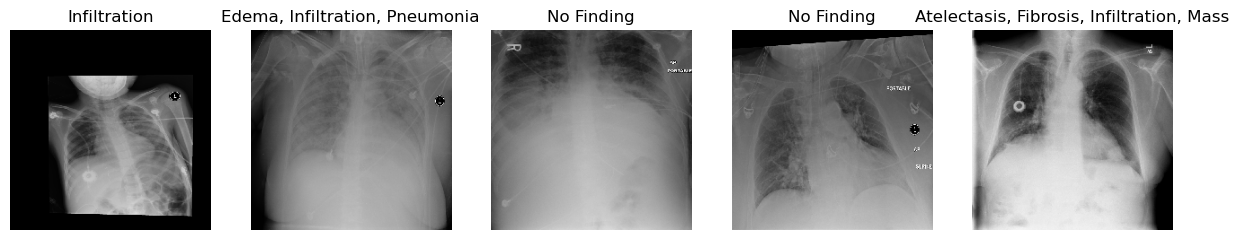

In [18]:
# Pegando um batch de imagens e rótulos
batch_images, batch_labels = next(train_generator)

# Criar uma figura com 5 imagens
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    axes[i].imshow(batch_images[i])  # Exibir imagem
    axes[i].axis('off')  # Remover eixos
    
    # Obtendo os rótulos ativos para a imagem
    label_indices = np.where(batch_labels[i] == 1)[0]
    labels = [classes[idx] for idx in label_indices]
    
    # Adicionando título com os rótulos da imagem
    axes[i].set_title(", ".join(labels))

plt.show()

# Criação das Camadas e Modelo CNN
<br>

##### Aqui tive que tomar uma decisão entre fazer uma CNN do zero ou usar um modelo pré-treinado(transfer learning). Apesar de precisar de muito mais dados para alcançar uma alta precisão e levar muito mais tempo para processar as imagens sem um GPU/CPU potênte, eu optei por fazer do zero. 🤡💪😫
<br>

##### Provavelmente não vai ser possível alcançar um nível super alto de precisão dos rótulos, porém dessa forma vou ter muito mais flexibilidade nos ajustes e vou aprender muito mais dessa forma.

### Revisão do DataGenerator <a id="Revisão_do_DataGenerator"></a>
<br>

##### A principio não iria fazer grandes alterações no DataGenerator, porém para deixar um pouco mais completo e evitar um overfitting nos resultados, decidi incluir algumas pequenas alterações apenas nos dados de treino, para manter a validação fidedigna ao exame. 
<br>

##### O que foi incluido?
##### Agora as imagens são carregadas podendo ter uma leve rotação de 10º, pode ser levemende movimentada para o lado ou para cima, pode dar um pequeno zoom, essas alterações são chamadas Data Augmentation.
<br>

##### Além disso devido ao problema de poder computacional vs tempo, também foi diminuido drasticamente o tamanho da imagem, aumentei o batch_size

In [19]:
del datagen, train_generator, val_generator  # Remove os objetos da memória RAM

# USAR df_modelado_reduzido PARA TESTES
## Obs: Se usar, alterar nos train_generator e val_generator

In [20]:
df_modelado_reduzido = df_modelado.sample(frac=0.1, random_state=42)  # Usa 10% dos dados

In [21]:
batch_size = 8  # Era 32, aumentei para 64

# Criar data augmentation para TREINO
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  
    rotation_range=10,  # Rotação até 10 graus
    width_shift_range=0.1,  # Deslocamento horizontal até 10% da imagem
    height_shift_range=0.1,  # Deslocamento vertical até 10%
    zoom_range=0.1  # Zoom até 10%
)

# Criar data generator para VALIDAÇÃO (sem augmentação)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Criando o generator de TREINO
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_modelado_reduzido,
    x_col="image_path",
    y_col=classes,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="raw",
    subset="training",
    shuffle=True
)

# Criando o generator de VALIDAÇÃO
val_generator = val_datagen.flow_from_dataframe(
    dataframe=df_modelado_reduzido,
    x_col="image_path",
    y_col=classes,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="raw",
    subset="validation",
    shuffle=False
)

Found 8970 validated image filenames.
Found 2242 validated image filenames.


### Sequential e API Funcional do Keras
<br>

##### Em meu ultimo projeto, usei o Sequential para criar as camadas do modelo (da forma que deixei abaixo), porém da pra fazer de uma forma mais "manual", deixando passo a passo, primeiramente eu pensei nisso pois seria mais fácil de comentar sobre cada camada criada, porém eu vi que pode ter algumas vantagens também deixando mais flexivel e podendo até combinar tipos de modelos diferentes como CNN junto a RNN.

In [22]:
# ASSIM SERIA O SEQUENTIAL

'''model = Sequential([
    # Camada 1: Convolucional + MaxPooling
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    # Camada 2: Convolucional + MaxPooling
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Camada 3: Convolucional + MaxPooling
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Camada Flatten
    Flatten(),

    # Camada Densa + Dropout
    Dense(256, activation='relu'),
    Dropout(0.5),

    # Camada de saída (Multi-label)
    Dense(len(classes), activation='sigmoid')
])

# Resumo do modelo
model.summary()'''

"model = Sequential([\n    # Camada 1: Convolucional + MaxPooling\n    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),\n    MaxPooling2D(2, 2),\n\n    # Camada 2: Convolucional + MaxPooling\n    Conv2D(64, (3, 3), activation='relu'),\n    MaxPooling2D(2, 2),\n\n    # Camada 3: Convolucional + MaxPooling\n    Conv2D(128, (3, 3), activation='relu'),\n    MaxPooling2D(2, 2),\n\n    # Camada Flatten\n    Flatten(),\n\n    # Camada Densa + Dropout\n    Dense(256, activation='relu'),\n    Dropout(0.5),\n\n    # Camada de saída (Multi-label)\n    Dense(len(classes), activation='sigmoid')\n])\n\n# Resumo do modelo\nmodel.summary()"

# ------------------------------------------------------------------------
##### agora sim, inicio do modelo!

#### Definir a Entrada do Modelo
<br>
    
##### obs: Diferente do Sequential, aqui precisar deixar explicito a criação da entrada esperada.

In [23]:
# Entrada do modelo, 224/224 são as dimensões de tamanho  em pixel e o 3 de canais RGB
inputs = Input(shape=(224, 224, 3))

#### Primeiras Camadas
<br>

##### Essas camadas vão ser responsáveis por aprender de forma mais geral, "um olhar mais abrangente", vai ter acesso da imagem como um todo.

#### Função ReLU e Sequencia de Camadas
<br>

##### A função ReLU remove valores negativos e mantém apenas valores positivos, acelerando o aprendizado.
##### Diferente do Sequential, aqui a sequencia é dada chamando os valores passados anteriormente, que nesse caso foi iniciado pelo "inputs", esse valor é passado adiante pela variável x.

### Pooling
<br>

##### Antes de prosseguir para a próxima etapa convolucional o pooling está diminuindo a imagem pela metade. O valor de 2/2 significa que a cada 2 por 2 pixels o maior valor vai se manter, essa janela 2 por 2 vai se movimentando devido ao parâmetro passado em strides até que a imagem termine, isso vai gerar uma nova imagem menor  e que para os olhos humanos tem nada haver com nada, mas pra máquina isso ajuda pois as caracteristicas mais importantes vão ser mantidas, vai processar mais rápido e melhora a generalização, preservando as principais caracteristicas. PORÉM!
<br>

#### Padding Same
##### O padding com o valor same faz com que zeros sejam adicionados em volta da imagem, assim os pixels percorridos não perdem as informações trazidas na borda e além disso mantem o tamanho das imagens para filtros futuros.

In [24]:
# Aqui temos 32 neurônios/filtros, 3/3 é o tamanho em pixel que serve para "varrer a imagem"
x = Conv2D(32, (3,3), activation='relu', padding='same')(inputs) # aqui,
x = Conv2D(32, (3,3), activation='relu', padding='same')(x) # E aqui, percorre a imagem coletando info
x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x) # aqui corta pela metade a imagem

### Terceira e Quarta Camadas
<br>

##### Para a segunda a terceira camada o processo está sendo repetido, porém o número de neurônios está dobrando e a imagem continua sendo quebrada pela metade, isso faz com que essas camadas sejam especialistas em pegar pequenos detalhes.

In [25]:
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)

In [26]:
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)

In [27]:
x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)

x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)

### Flatten e Camada Densa
<br>

##### As camadas anteriores trabalham com matrizes e a camada densa espera um vetor, o Flatten simplesmente transforma tudo para uma única linha em forma de vetor.
<br>

##### A camada densa por sua vez tem muitos neuronios, mas somente metade vai ser ativada por conta do Dropout, isso serve para dar uma certa aleatoriedade e impedir que o modelo "memorize" os dados de treino e dar mais generalização, mesmo assim 2048 neuronios é uma quantidade bem elevada, pois é aqui que turo que foi filtrado anteriormente vai se juntar para passar  para a camada de saída e tomar a decisão da classe.

In [28]:
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

### Camada de Saída
<br>

##### Aqui é onde vamos obter nossa resposta, len(classes) passa a quantidade de neurônios para poder classificar cada doença/condição, que são 15. A função sigmoid é usada pois cada imagem pode ter mais de uma doença/condição ao mesmo tempo.
<br>

##### Basicamente o calculo de sigmoid vai definir um valor resposta de 0 a 1 mas no final classifica ou como 0 ou como 1, se o resultado final for 0.235 ele vai deixar 0, se for 0.69 vai como 1, sendo que quanto mais próximo dos extremos, maior a certeza de ter acertado a classificação. O legal dessa função é que podemos trabalhar com esses valores e por exemplo deixar estipulado que apenas valores acima de 0,80 devem ser classificados como 1.
<br>

##### Vídeo sobre sigmoid
<https://www.youtube.com/watch?v=Cu5u9lbwEV0>


In [29]:
outputs = Dense(len(classes), activation='sigmoid')(x)

### Criação do Modelo 🎉
<br>

##### Aqui o imputs ta recebendo os dados pelo inputs que é a variável criada lá no começo usando a função Input()
##### e gerando a saída pelo outputs que é a variável criada para receber a camada Densa.

In [30]:
model = Model(inputs=inputs, outputs=outputs)

### Otimizador, Taxa de Aprendizado, Função de perda, Métrica
<br>

##### A compilação do modelo é extremamente importante, é aqui que vai ser criado o "guia" que vai passar por todas camadas criadas, como o modelo vai se adaptar diante dos erros, como vai evoluir até chegar a um bom resultado.
<br>

##### A escolha do Adam e do learning_rate 0.0001 é quase que padrão, o Adam combina outros otimizadores como SGD e RMSProp, ele se adapta a taxa de aprendizado, tem uma boa convergência e precisa de menos ajustes; Já o learning rate é o quanto a função de perda vai mudar para chegar a resposta correta, um valor muito alto podem resultar em "saltos" muito altos e acabar "passando" da resposta certa e muito pequeno(menor do que já está) pode deixar muito custoso o treino ou até entrar em problema de mínimos locais. 

##### A função de perda binary_crossentropy é perfeita para o caso em questão, é usada para multi-classificação binária, que é a nossa ausência ou presença de algo no raio-X

##### A métrica inicialmente usada será a acurácia que mede a quantidade de acerto vs a quantidade de dados previstos, mas posteriormente pode-se medir com outros também como precision, recall ou f1.

In [31]:
# Compilação do modelo
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Callbacks
<br>

##### Os callbacks são funções que podem ser chamadas durante o treinamento do modelo, modificando o comportamento do treinamento quando acontece eventos específicos, como o final de uma época por exemplo.
<br>

##### O que é o val_loss?
##### O val_loss é a perda de validação, é a função de perda(loss function) porém aplicada ao conjunto de validação separada anteriormente pelo ImageDataGenerator, isso é feito em paralelo ao treinamento para identificar um possível overfitting durante o treino.
<br>

##### Batch e Epoch?
##### Epoch é a quantidade de vezes que o modelo vai passar por todas imagens, batch(lote) é o número de imagens que vão ser vistas antes do modelo atualizar os pesos, sem batch o modelo atualiza o peso a cada imagem vista.
<br>

##### O Callback usado foi o a parada antecipada(EarlyStopping) que usa a perda de validação, isso significa que se o conjunto de validação estiver com a função de perda sem melhorar durante 5 épocas, então o treinamento é interrompido, além disso os pesos são restaurados para os melhores resultados (pois podem piorar nesse avanço do patience)

### Definindo SAVE dos pesos durante o treino
<br>

##### Além das funções para ajustar o treinamento, percebi que o poder de processamento é uma enorme barreira pra terminar o treino a tempo, então é importante salvar o progresso do treino, por isso também foi definido no model_checkpoint para que salvasse os pesos a cada epoch concluído com o nome de "checkpoint_epoch_{epoch:02d}.keras" onde epoch:02d é o número do epoch em questão.

In [32]:
# Definir callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Antes eu estava usando assim, mas devido o tempo de processamento criei saves por epoch, como abaixo
#model_checkpoint = ModelCheckpoint('melhor_modelo.keras', save_best_only=True)

# Salvar os pesos a cada epoch
checkpoint_path = "checkpoint_epoch_{epoch:02d}.weights.h5"
model_checkpoint = ModelCheckpoint(checkpoint_path, save_weights_only=True, save_freq='epoch')

### Verificando se tem treino/epochs salvos

In [33]:
# Procurar o último checkpoint salvo
ultimo_checkpoint = None
ultima_epoch = 0

ultimo_checkpoint = None
for epoch in range(10, 0, -1):  # Busca do último checkpoint começando do final
    checkpoint_file = f"checkpoint_epoch_{epoch:02d}.keras"
    if os.path.exists(checkpoint_file):
        ultimo_checkpoint = checkpoint_file
        ultima_epoch = epoch
        break

# Se encontrar um checkpoint, carregar os pesos
if ultimo_checkpoint:
    print(f"Carregando pesos de {ultimo_checkpoint}")
    model.load_weights(ultimo_checkpoint)
    initial_epoch = ultima_epoch  # Define de onde continuar
else:
    initial_epoch = 0  # Começa do zero se não houver checkpoint

### Callback do SaveHistory
<br>

##### Já foram criados os Callbacks do early_stopping e model_checkpoint, porém o checkpoint salva apenas os pesos e não salva o acompanhamento das métricas, então abaixo foi criado uma função para o criar o save_history_callback, além disso caso já tenha o arquivo history.pkl salvo, ele carrega e começa da onde parou.

In [34]:
class SaveHistory(Callback):
    def __init__(self, history_file='history.pkl'):
        self.history_file = history_file
        self.history = {}

        if os.path.exists(self.history_file):
            with open(self.history_file, 'rb') as f:
                self.history = pickle.load(f)

    def on_train_begin(self, logs=None):
        """Evita recarregar o histórico várias vezes."""
        if os.path.exists(self.history_file):
            with open(self.history_file, 'rb') as f:
                self.history = pickle.load(f)

    def on_epoch_end(self, epoch, logs=None): # O ON_EPOCH_END defini que será salvo a cada epoch concluído
        if logs:
            for key, value in logs.items():
                self.history.setdefault(key, []).append(value)

            with open(self.history_file, 'wb') as f:
                pickle.dump(self.history, f)

            print(f"Histórico salvo após a epoch {epoch+1}")
            
            
            
# Criar callback para salvar histórico após cada epoch
save_history_callback = SaveHistory()

### Treinando o Modelo <a id="Treinando_o_Modelo"></a>
<br>

##### O Treinamento do modelo é passado pelo model.fit, é usado os parâmetros dentro de train_generator, usado o val_generator para saber os val_loss do early_stopping, passado os callbacks e definido 30 épocas.
<br>

([volte para train generator](#Revisão_do_DataGenerator))

In [35]:
# Treinamento do modelo
history = model.fit(
    train_generator,
    validation_data=val_generator,
    initial_epoch=initial_epoch,   # incluido essa linha para continuar da onde parou
    epochs=10,  
    callbacks=[early_stopping, model_checkpoint, save_history_callback]
)

C:\Users\Bill_\anaconda3\envs\DeepLearn\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4636 - loss: 0.2836Histórico salvo após a epoch 1
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1412s 1s/step - accuracy: 0.4637 - loss: 0.2836 - val_accuracy: 0.5513 - val_loss: 0.2133
Epoch 2/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5339 - loss: 0.2282Histórico salvo após a epoch 2
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1347s 1s/step - accuracy: 0.5339 - loss: 0.2282 - val_accuracy: 0.5513 - val_loss: 0.2221
Epoch 3/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5327 - loss: 0.2240Histórico salvo após a epoch 3
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1356s 1s/step - accuracy: 0.5327 - loss: 0.2240 - val_accuracy: 0.5513 - val_loss: 0.2100
Epoch 4/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5434 - loss: 0.2206Histórico salvo após a epoch 4
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1362s 1s/step - accuracy: 0.5434 - loss: 0.2206 - val_accuracy: 0.5513 - val_loss: 0.2129
Epoch 5/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/

### Avaliação Inicial

# Avaliar o modelo
loss, accuracy = model.evaluate(val_generator)
print(f'Perda: {loss}, Acurácia: {accuracy}')

# Visualização do desempenho


# Perda


# Acurácia


[Voltar para a Seção 1](#Treinando_o_Modelo)